In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt
import random
import itertools
import pickle
from settings import *

In [2]:
#TODO: resumen del proceso
#1 cargar todas diccionario con line index y sentence
#2 elminiar las mas largas de 50
#3 añadir las palabras al vocabulario
#4 eliminar las sentence con palabras que no salen
#5 pasar los pares con line index contiguos

In [3]:
# n_lines = 0
# with open(corpus, 'rb') as file:
#     for line in file:
#         n_lines += 1
# print(f'Numero de líneas: {n_lines}')

n_lines = 213_517_354
f"Lineas usadas sobre el total:{LINES_USED/n_lines:.3%}"

'Lineas usadas sobre el total:1.171%'

In [4]:
def printLines(stop=10, decode=False):
    with open(corpus, 'rb') as datafile:
        for i,line in enumerate(datafile):
            
            if decode:
                print(i,line.decode("utf-8"))
            else:
                print(i,line)
            if i==stop: break

printLines(10,True)

0 NETKonet trae para ti...

1 "Twenty"

2 [NEW Presenta]

3 [Una producción de A M Tree Pictures]

4 [Sidus HQ]

5 [Productor ejecutivo:

6 Kim Woo Taek]

7 Somos los típicos amigos de la secundaria que juraron que su amistad duraría para siempre.

8 Aunque las circunstancias del inicio de nuestra amistad no fueron especiales en cierto modo fueron especiales para nosotros.

9 Ejem... ejem.

10 Ejem...



In [6]:
#funcion para buscar ejemplos a la hora de tratar la puntuacion
def search_line(search_string,stop=10):
    n=0
    prev_line,line_found = "",""
    prnt = False
    
    with open(corpus, 'rb') as datafile:
        for i,line in enumerate(datafile):
            if prnt:
                print("-------------")
                print(prev_line.decode("utf-8"),line_found.decode("utf-8"),
                      line.decode("utf-8"), sep="\n")
                prnt = False
                n+=1
                if n==stop:
                    break
            if search_string in line: 
                line_found = line
                prnt = True
            else:
                prev_line = line
                
search_line(b". ",100)

-------------
Aunque las circunstancias del inicio de nuestra amistad no fueron especiales en cierto modo fueron especiales para nosotros.

Ejem... ejem.

Ejem...

-------------
- Háganlo con Piedra, Papel o tijeras.

- Es una buena idea. ¡Hagámoslo!

Ok, solo haremos una ronda, como hombres.

-------------
Lamento no habértelo dicho primero.

Aunque ahora estemos rompiendo... como amigo y compañero de clase, siempre te desearé lo mejor.

¡Fighting!

-------------
Entre el sueño y la realidad.

Hasta este punto, todos los errores que hemos cometido en el pasado... se perdonan porque éramos jóvenes y nos faltaba experiencia en la vida.

Sin embargo, parados aquí, mayores y más experimentados...

-------------
Hay algo que ustedes no entienden.

Este no es solamente un camino bifurcado... si no que hay tres caminos para elegir.

- Yo iré por este camino.

-------------
Mi padre murió a los 40, y Mozart murió cuando tenía 35.

- Kurt Cobain murió a los 27. ¡27!

- Kurt Cobain se suicidó.


In [8]:
#Procesado de la puntuación
def process_punct(s):#complejo
    s = s.strip().lower().decode()
    s = re.sub(r"\.000",r" mil", s)
    s = re.sub(r"^-",       r"<GUION_INIC>", s)
    s = re.sub(r"-{2}",     r"<GUION_DOBL>", s)
    s = re.sub(r"\.{3}",    r"<TRIP_DOT>", s)
    s = re.sub(r"{y:bi}",   r"<SPECIAL_1>", s)
    s = re.sub(r"(\w)-(\w)",r"\1<GUION_INTER>\2", s)
    s = re.sub(r"([\):!?])",r" \1", s)      #separa puntuacion con espacio antes
    s = re.sub(r"([\(¡¿])", r"\1 ", s)      #separa puntuacion con espacio despues
    s = re.sub(r"([\"-,¿\.}])", r" \1 ", s) #espacio antes y despues
    
    #separa los tokens
    s = re.sub(r"<", r" <", s)
    s = re.sub(r">", r"> ", s)
    
    s = re.sub(r"\s<GUION_INTER>\s",r"-", s)
    return s

import unicodedata
def process_punct(s): #simple #punct2
    s = s.strip().lower().decode()
    s = re.sub(r"^-",       r"<GUION_INIC>", s)
    s = re.sub(r"\.{3}",    r"<TRIP_DOT>", s)
    s = re.sub(r"{y:bi}",   r"<TKN_A>", s)
    s = ''.join((c for c in unicodedata.normalize('NFD',s) if unicodedata.category(c) != 'Mn')) #quita tildes
    s = re.sub(r"([.¡!¿?])", r" \1 ", s)
    s = re.sub(r"[^a-zA-Z.¡!¿?<>_\d]+", r" ", s)
    s = re.sub(r"\s+", r" ", s).strip()
    
    s = re.sub(r"<", r" <", s)
    s = re.sub(r">", r"> ", s)
    return s

def process_punct(l): #basico punct3
    s = l.lstrip(b"-").strip().lower().decode() #elimina guion del principio de algunas lineas
    s = re.sub(r"([.!?])", r" \1", s) #separa puntuacion
    s = re.sub(r"([.¡¿])", r"\1 ", s) #separa puntuacion
    s = re.sub(r"[,]",r"",s) #quita las comas
    return s

print("#Test  0:", process_punct("-t. -t".encode()))
print("#Test  1:", process_punct("t. .t ¿t? ¿¿¿t???".encode()))
print("#Test  2:", process_punct("".encode()))
print("#Test  3:", process_punct("...t...".encode()))
print("#Test  4:", process_punct("???...!!!".encode()))
print("#Test  5:", process_punct('"¿Cómo?"'.encode()))
print("#Test  6:", process_punct('(--8:)'.encode()))
print("#Test  7:", process_punct('electro-quimico'.encode()))
print("#Test  8:", process_punct('que--'.encode()))
print("#Test  9:", process_punct('-ivanov'.encode()))
print("#Test 10:", process_punct('10.000, 5:45'.encode()))
print("#Test 11:", process_punct('8:00 8:00h'.encode()))
print("#Test 12:", process_punct('.¿ -¿'.encode()))
print("#Test 13:", process_punct('{y:bi}vamos'.encode()))

#Test  0: t .  -t
#Test  1: t .   . t ¿ t ? ¿ ¿ ¿ t ? ? ?
#Test  2: 
#Test  3:  .  .  . t .  .  . 
#Test  4:  ? ? ? .  .  .  ! ! !
#Test  5: "¿ cómo ?"
#Test  6: (--8:)
#Test  7: electro-quimico
#Test  8: que--
#Test  9: ivanov
#Test 10: 10 . 000 5:45
#Test 11: 8:00 8:00h
#Test 12:  . ¿  -¿ 
#Test 13: {y:bi}vamos


In [9]:
def loadLines(file, total_lines=10, max_lenght=MAX_LENGTH):
    with open(file, 'rb') as datafile:
        n=0
        for i,line in enumerate(datafile):
            if max(line.find(b"["),line.find(b"]")) == -1: #filtra los comentarios
                s = process_punct(line)
                s = s.strip().split()
                if len(s) < max_lenght: #filtra frases largas
                    n+=1
                    yield i,s
            if n==total_lines: break
                
# for i,l in loadLines(corpus,10): print(i,l)

In [10]:
# Default word tokens
class Voc:
    def __init__(self, name):
        self.name = name
        self.trimmed = False
        self.word2index = {"UNK": UNK_token}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3  # Count SOS, EOS, PAD

    def addSentence(self, spl_sent):
        for word in spl_sent:
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1

    # Remove words below a certain count threshold
    def trim(self, min_count):
        if self.trimmed:
            return
        self.trimmed = True

        keep_words = []

        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)

        print(f"keep_words {len(keep_words)} / { len(self.word2index)} = "
              f"{len(keep_words) / len(self.word2index):.4f}")

        # Reinitialize dictionaries
        self.word2index = {"UNK": UNK_token}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS", UNK_token:"UNK"}
        self.num_words = 4 # Count default tokens

        for word in keep_words:
            self.addWord(word)

Número de palabras: 145710


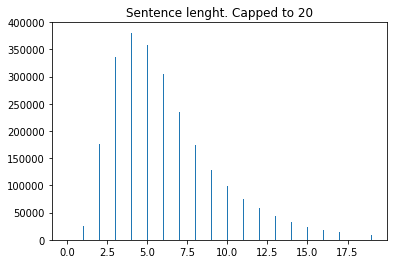

CPU times: user 1min 11s, sys: 624 ms, total: 1min 11s
Wall time: 1min 12s


In [11]:
%%time
#TODO: multicpu
voc = Voc(corpus_name)

hist = []  
for i,s in loadLines(corpus,LINES_USED):
    s_l = len(s)
    hist.append(s_l)
    voc.addSentence(s)
    
print(f'Número de palabras: {voc.num_words}')

arr = np.array(hist)
plt.hist(arr, bins='auto')  # arguments are passed to np.histogram
plt.title(f"Sentence lenght. Capped to {MAX_LENGTH}")
plt.show()

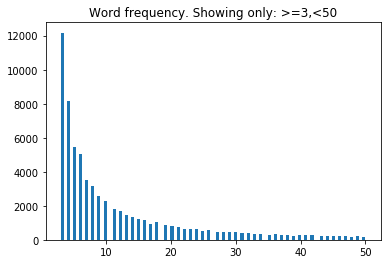

In [12]:
hist=[]
for i,n in enumerate(voc.word2count):
    c = voc.word2count[n]
    if c>=3:
        hist.append(c)
        
arr = np.array(hist)
plt.hist(arr, bins=100,range=(3,50))  # arguments are passed to np.histogram
plt.title(f"Word frequency. Showing only: >=3,<50")
plt.show()

In [13]:
from collections import Counter
c = Counter(voc.word2count)
c.most_common()

[('.', 2083836),
 ('?', 463501),
 ('¿', 429204),
 ('no', 372953),
 ('que', 363623),
 ('de', 360544),
 ('a', 269994),
 ('la', 247720),
 ('!', 245749),
 ('el', 211204),
 ('¡', 208865),
 ('es', 198739),
 ('y', 175049),
 ('en', 169791),
 ('lo', 166757),
 ('un', 163205),
 ('qué', 135941),
 ('me', 126913),
 ('por', 123025),
 ('una', 103530),
 ('te', 96120),
 ('se', 92153),
 ('los', 82529),
 ('con', 79995),
 ('para', 72004),
 ('está', 71586),
 ('si', 67175),
 ('mi', 65596),
 ('pero', 65485),
 ('sí', 64417),
 ('yo', 59955),
 ('eso', 56603),
 ('las', 55043),
 ('bien', 54947),
 ('su', 53706),
 ('le', 48779),
 ('aquí', 47092),
 ('al', 46639),
 ('más', 42891),
 ('del', 42722),
 ('como', 41998),
 ('tu', 41601),
 ('ya', 38588),
 ('todo', 35653),
 ('esto', 34252),
 ('ha', 32894),
 ('muy', 32309),
 ('vamos', 30796),
 ('hay', 30501),
 ('ahora', 30372),
 ('esta', 29265),
 ('nada', 29175),
 ('algo', 28679),
 ('estoy', 28403),
 ('tú', 28350),
 ('nos', 28149),
 ('tengo', 27651),
 ('así', 27544),
 ('cómo', 

In [14]:
#Check de la puntuacion
import string 
print(string.punctuation)

punt_dict = {}
for word in c:
    for punt in string.punctuation:#",.¿?¡!\":()-{}":
        if punt in word:
            if len(word)>1 and c[word]>3:
                punt_dict[word] = c[word]
c2 = Counter(punt_dict)
c2.most_common()

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


[('?"', 1854),
 ('"¿', 1595),
 ('"el', 1375),
 ('!"', 1018),
 ('"no', 1013),
 ('"la', 914),
 ('"¡', 871),
 ('"dude"', 733),
 ('dijo:', 500),
 ('"y', 457),
 ('dice:', 424),
 ('dije:', 408),
 ("goa'uld", 392),
 ("teal'c", 354),
 ('"te', 352),
 ('"si', 327),
 ('"a', 293),
 ('"lo', 257),
 ('"los', 249),
 ('"no"', 244),
 ("d'artagnan", 242),
 ('"mi', 240),
 ('$50', 235),
 ('"un', 222),
 ('esto:', 217),
 ('$20', 216),
 ('"en', 209),
 ('"me', 203),
 ('-¿', 203),
 ('decir:', 194),
 ("b'elanna", 193),
 ('(music)', 190),
 ('--', 179),
 ('es:', 175),
 ('"es', 174),
 ('"yo', 174),
 ('"una', 174),
 ('"por', 169),
 ('"que', 169),
 ("son'a", 168),
 ("i'm", 161),
 ('"se', 160),
 ("it's", 155),
 ('"para', 153),
 ('$10', 151),
 ('10:00', 151),
 ('"sí', 151),
 ('que--', 150),
 ("o'neill", 146),
 ('"las', 145),
 ('3:00', 144),
 ("g'kar", 144),
 ('{y:bi}¿', 144),
 ('cosa:', 143),
 ("tok'ra", 142),
 ('por:', 139),
 ("ma'am", 135),
 ('"sí"', 134),
 ('dos:', 134),
 ('8:00', 133),
 ('"cuando', 131),
 ('"de', 1

In [15]:
voc.trim(MIN_COUNT)

keep_words 38397 / 145708 = 0.2635


In [16]:
def has_trimmed_or_unk(spl_snt):
    """ Filter out sentences with trimmed words or words not in the voc
    spl_snt is a list of words"""
    for word in spl_snt:
        if word not in voc.word2index:
            return True

In [17]:
trm_unk = 0
for i,s in loadLines(corpus,LINES_USED):
    if has_trimmed_or_unk(s): trm_unk +=1
        
full_pairs =  LINES_USED - trm_unk      

print(f"From {LINES_USED} pairs, {full_pairs} does not contain trimmed or unkonwn words,", 
      f"{full_pairs / LINES_USED:.4f} of total")

From 2500000 pairs, 2252051 does not contain trimmed or unkonwn words, 0.9008 of total


In [18]:
#aumentando min_count de 3 a 5 el vocabulario pasa de 72510(57%) a 36642(29%), sin embargo las frases aceptadas 
#solo baja un 6%, de 97.33% a 91.27%, o lo que es más impactante, con un tercio del vocabulario total podemos 
#recrear más del 90% del dataset , TODO restestear con diferentes min count cuando este el multicpu

In [19]:
# spl_snt is a list of words
def indexesFromSentence(spl_snt, voc):
    idxs = []
    for word in spl_snt:
        try:
            idxs += [voc.word2index[word]]
        except:
            idxs += [UNK_token] #word2index["UNK"]=UNK_token
    return idxs + [EOS_token]

def gen_pairs(how_many, voc):
    first_inp = True
    n=0
    for out_idx, out_snt in loadLines(corpus,LINES_USED):
        
        if first_inp: #first cycle, set first input
            inp_idx, inp_snt = out_idx, out_snt
            first_inp = False
            continue

        if inp_idx+1 == out_idx: #frases contiguas (loadLines filter long sentences)
            ok_inp = True if WITH_UNK else not has_trimmed_or_unk(inp_snt) # if WITH_UNK==True, every inp is accepted
            ok_out = not has_trimmed_or_unk(out_snt)
            
            if ok_inp and ok_out: #every word is in Voc
                n+=1
                yield [indexesFromSentence(inp_snt, voc),indexesFromSentence(out_snt, voc)]
        
        if n==how_many:break
        inp_idx, inp_snt = out_idx, out_snt #prepare next cycle
        
for pair in gen_pairs(10,voc): print(pair)

[[8, 9, 10, 11, 12, 13, 14, 15, 3, 15, 16, 17, 18, 5, 19, 7, 2], [20, 21, 22, 23, 24, 12, 25, 17, 26, 27, 28, 29, 30, 31, 27, 28, 5, 32, 7, 2]]
[[20, 21, 22, 23, 24, 12, 25, 17, 26, 27, 28, 29, 30, 31, 27, 28, 5, 32, 7, 2], [33, 7, 7, 7, 33, 7, 2]]
[[33, 7, 7, 7, 33, 7, 2], [33, 7, 7, 7, 2]]
[[34, 35, 3, 36, 37, 38, 3, 39, 40, 2], [26, 7, 2]]
[[26, 41, 42, 3, 43, 44, 45, 46, 3, 7, 2], [47, 48, 49, 7, 2]]
[[47, 48, 49, 7, 2], [34, 50, 51, 52, 53, 40, 2]]
[[34, 50, 51, 52, 53, 40, 2], [34, 54, 15, 55, 52, 53, 56, 40, 2]]
[[34, 54, 15, 55, 52, 53, 56, 40, 2], [57, 15, 58, 26, 8, 59, 7, 2]]
[[57, 15, 58, 26, 8, 59, 7, 2], [34, 29, 60, 61, 62, 5, 63, 64, 65, 52, 66, 40, 2]]
[[34, 29, 60, 61, 62, 5, 63, 64, 65, 52, 66, 40, 2], [67, 68, 12, 69, 70, 7, 2]]


In [20]:
#check finales paris
for pair in gen_pairs(10,voc): 
    for i in pair:
        snt = []
        for idx in i:
            snt += [voc.index2word[idx]]
        print(*snt)
    print("---")

somos los tipicos amigos de la secundaria que UNK que su amistad duraria para siempre . EOS
aunque las circunstancias del inicio de nuestra amistad no fueron especiales en cierto modo fueron especiales para nosotros . EOS
---
aunque las circunstancias del inicio de nuestra amistad no fueron especiales en cierto modo fueron especiales para nosotros . EOS
ejem <TRIP_DOT> ejem . EOS
---
ejem <TRIP_DOT> ejem . EOS
ejem <TRIP_DOT> EOS
---
<GUION_INIC> ¿ le UNK el pecho a UNK min ? EOS
<GUION_INIC> no . EOS
---
no se lo UNK me quede alli parado UNK . EOS
<GUION_INIC> debes estar demente . EOS
---
<GUION_INIC> debes estar demente . EOS
<GUION_INIC> ¿ eso es una pregunta ? EOS
---
<GUION_INIC> ¿ eso es una pregunta ? EOS
¿ crees que fue una pregunta idiota ? EOS
---
¿ crees que fue una pregunta idiota ? EOS
ey que ya no somos ninos . EOS
---
ey que ya no somos ninos . EOS
¿ en que estaban pensando para pelear asi por una chica ? EOS
---
¿ en que estaban pensando para pelear asi por una chica ?

In [20]:
pairs = list(gen_pairs(LINES_USED,voc))

In [21]:
"""
se obtienen menos pares que lineas usadas, con lineas usadas se crea el diccionario, con ese diccionario elegimos 
las palabras con las que quedarnos, se descartan las lineas con palabras borradas y de ahi solo cogemos los pares
de lineas contiguos
"""
len(pairs)

2218344

In [22]:
#Guardar pairs y voc
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
with open(save_dir + '/pairs.pkl', 'wb') as file:
    pickle.dump(pairs, file)

with open(save_dir + '/voc.pkl', 'wb') as file:
    voc.__module__ = "Voc"
    pickle.dump(voc, file)

In [ ]:
# # Example for validation of the code
# small_batch_size = 6
# pairs_list = [random.choice(pairs) for _ in range(small_batch_size)]
# batches = batch2TrainData(pairs_list)
# input_variable, lengths, target_variable, mask, max_target_len = batches

# print("input_variable:\n", input_variable)
# print("lengths:", lengths)
# print("target_variable:\n", target_variable)
# print("mask:\n", mask)
# print("max_target_len:", max_target_len)